## Main notebook for the preprocessing-sorting-postprocessing pipeline with SpikeInterface

### Imports

In [43]:
import os
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import json
import spikeinterface.full as si
from probeinterface import read_probeinterface
from probeinterface.plotting import plot_probe
from adc_shifts import adc_shifts

%matplotlib widget

### Set pipeline parameters

In [44]:
pipeline_info_dict = {}

In [45]:
# Data loading
num_channels = 384
sampling_frequency = 29999.954846
# see this thread https://community.brain-map.org/t/using-the-raw-data/1898 for gain scaling factor and dtype
gain_recording = 0.195
offset_recording = 0
dtype = np.int16

pipeline_info_dict.update({'num_channels': num_channels, 'sampling_frequency': sampling_frequency, 'gain_recording': gain_recording, 'offset_recording': offset_recording, 'dtype': dtype})

In [46]:
# Preprocessing and sorting
highpass_frequency = 150 # Hz

sorter_name = 'kilosort3'
sorter_path = Path.home() / 'RANCZLAB-NAS' / 'spikesorter_images' / f'{sorter_name}-compiled-base-sandbox'
output_folder = Path.home() / 'RANCZLAB-NAS/iakov/vestibular-vr_2024-01-17T144340Z_sorting_ks3_18_jan_bad_chan_removed'
remove_existing_folder = True

pipeline_info_dict.update({'sorter_name': sorter_name, 'sorter_path': sorter_path, 'output_folder': output_folder, 'remove_existing_folder': remove_existing_folder})

In [47]:
# Other
backend = 'ipywidgets'

pipeline_info_dict.update({'backend': backend})

### Loading the data

#### Reading the binary file

In [48]:
# Main working directory
base_folder = Path.home() / 'RANCZLAB-NAS' / 'vestibular-vr_2024-01-17T144340Z'

# Input data
binary_filename = 'SpikeData.bin'

# # Output sorting
# output_folder = base_folder / 'kilosort3_sorting_files'
# sorting_save_path = base_folder / 'kilosort3_sorting_output'

pipeline_info_dict.update({'data_path': base_folder, 'binary_filename': binary_filename})

In [49]:
recordings = {}
recordings['raw'] = si.read_binary(base_folder / binary_filename, sampling_frequency=sampling_frequency, dtype=dtype, num_channels=num_channels, gain_to_uV=1.0, offset_to_uV=0)
recordings['raw'] = si.scale(recordings['raw'], gain=gain_recording, offset=offset_recording) #scale to uV
recordings['raw']

ScaleRecording: 384 channels - 30.0kHz - 1 segments - 16,642,440 samples - 554.75s (9.25 minutes) 
                float32 dtype - 23.81 GiB

#### Attaching the probe configuration

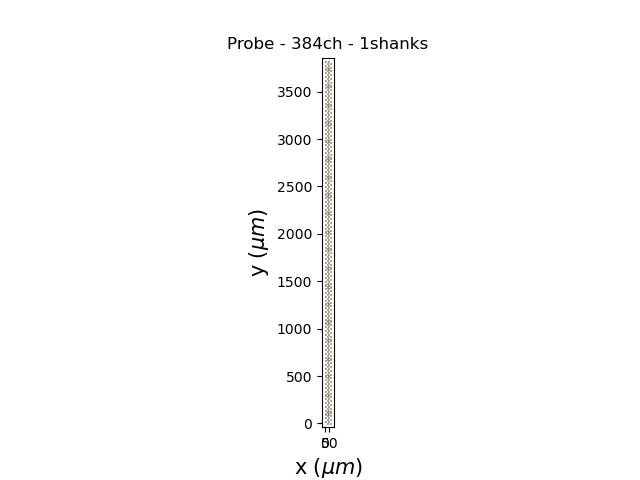

In [50]:
probegroup = read_probeinterface('np_json_files/np1.json')
probe = probegroup.probes[0]
recordings['raw'] = recordings['raw'].set_probe(probe)

plot_probe(probe)
plt.show()

### Preprocessing

In [51]:
# perform the phase shift (similar to IBL destriping or `tshift` option in CatGT):
recordings['preprocessed'] = si.phase_shift(recordings['raw'], inter_sample_shift=adc_shifts()[0])

In [ ]:
# detect noisy, dead, and out-of-brain channels
bad_channel_ids, channel_labels = si.detect_bad_channels(recordings['preprocessed'])
recordings['preprocessed'] = recordings['preprocessed'].remove_channels(remove_channel_ids=bad_channel_ids)

pipeline_info_dict.update({'channel_labels': channel_labels, 'bad_channel_ids': bad_channel_ids})

In [ ]:
print('Channels removed:', {k: channel_labels[k] for k in bad_channel_ids})

In [ ]:
recordings['preprocessed'] = si.highpass_filter(recordings['preprocessed'], freq_min=highpass_frequency)

In [ ]:
# subtract the median across all channels
recordings['preprocessed'] = si.common_reference(recordings['preprocessed'], operator="median", reference="global")

In [ ]:
parameter_dict = si.get_default_sorter_params(sorter_name)

In [ ]:
parameter_dict['projection_threshold'] = [10, 4]
parameter_dict['freq_min'] = 150
parameter_dict['minfr_goodchannels'] = 0.1
parameter_dict['freq_min'] = highpass_frequency
# parameter_dict['lam'] = 10 # default value already
parameter_dict['AUCsplit'] = 0.9
parameter_dict['minFR'] = 1/50
# parameter_dict['momentum'] = [20, 400] # default value already
parameter_dict['sigmaMask'] = 30
parameter_dict['preclust_threshold'] = 8
parameter_dict['skip_kilosort_preprocessing'] = False

# parameter_dict['scaleproc'] = 200

parameter_dict['n_jobs'] = -1

pipeline_info_dict.update({'parameter_dict': parameter_dict})

In [ ]:
print(parameter_dict)

### Plot raster

In [ ]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].set_title('Raw')
si.plot_traces(recordings['raw'], mode='map', time_range=[0, 0.1], backend='matplotlib', ax=ax[0])
ax[1].set_title('Preprocessed')
si.plot_traces(recordings['preprocessed'], mode='map', time_range=[0, 0.1], backend='matplotlib', ax=ax[1])
plt.show()

In [ ]:
si.plot_traces(recordings['preprocessed'], mode='map', time_range=[0, 0.1], backend=backend, height_cm=25, width_cm=60)

### Save pipeline information into json file

In [33]:
with open(output_folder/'pipeline_info.json', 'w') as fp:
    json.dump(pipeline_info_dict, fp)

FileNotFoundError: [Errno 2] No such file or directory: '/home/jupyter-ikharitonov/RANCZLAB-NAS/iakov/vestibular-vr_2024-01-17T144340Z_sorting_ks3_18_jan/pipeline_info.json'

### Run sorting

In [35]:
sorting = si.read_sorter_folder(output_folder)
sorting

Exception: This folder /home/jupyter-ikharitonov/RANCZLAB-NAS/iakov/vestibular-vr_2024-01-17T144340Z_sorting_ks3_18_jan does not have spikeinterface_log.json

In [ ]:
sorting = si.run_sorter(sorter_name, recording=recordings['preprocessed'], output_folder=output_folder, singularity_image=sorter_path, verbose=True, remove_existing_folder=remove_existing_folder, **parameter_dict)
sorting.save(folder=output_fo
             lder/'si_save', format='npz_folder', **parameter_dict)

### Postprocessing

In [37]:
sorting

KiloSortSortingExtractor: 335 units - 1 segments - 30.0kHz

In [38]:
# returns a new sorting object with putative double-counted spikes removed
cleaned_sorting = si.remove_duplicated_spikes(sorting=sorting, 
                                           censored_period_ms=0.3, # in ms
                                           method='keep_first')

In [39]:
cleaned_sorting

RemoveDuplicatedSpikesSorting: 335 units - 1 segments - 30.0kHz

In [40]:
# the waveforms are sparse so it is faster to export to phy
we = si.extract_waveforms(recording=recordings['preprocessed'], sorting=cleaned_sorting, folder='waveforms', unit_batch_size=800)

# compute some metrics needed for this module:
spike_amplitudes = si.compute_spike_amplitudes(waveform_extractor=we)
principal_components = si.compute_principal_components(waveform_extractor=we,
                                 n_components=5,
                                 mode='by_channel_global')

# save the data in a specified location
si.export_to_phy(waveform_extractor=we, 
              output_folder=output_folder/'phy_folder')

extract waveforms shared_memory multi buffer:   0%|          | 0/555 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [25]:
template_metrics = si.compute_template_metrics(we)
# display(template_metrics)

/opt/tljh/user/envs/jh_si_env/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/opt/tljh/user/envs/jh_si_env/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/opt/tljh/user/envs/jh_si_env/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [26]:
# # or load waveforms that have already been extracted:
# we = si.load_waveforms(folder='waveforms')

# # calculate metrics that don't require principal components:
# metrics = compute_quality_metrics(waveform_extractor=we)

# # or compute principal components before passing on the waveform extractor:
# pca = compute_principal_components(waveform_extractor=we, 
#                                    n_components=5, 
#                                    mode='by_channel_local')
metrics = si.compute_quality_metrics(waveform_extractor=we)

/opt/tljh/user/envs/jh_si_env/lib/python3.10/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:842: UserWarning: Units [15, 19, 20, 32, 33, 35, 36, 39, 47, 59, 60, 62, 64, 65, 68, 75, 108, 111, 113, 117, 120, 121, 122, 124, 127, 129, 130, 131, 134, 138, 140, 143, 144, 145, 146, 153, 154, 160, 162, 167, 170, 174, 175, 177, 178, 179, 183, 186, 187, 197, 205, 219, 231, 258, 259, 260, 264, 265, 267, 269, 270, 271, 272, 273, 275, 276, 277, 278, 279, 280, 283, 284, 293, 295, 297, 298, 301, 302, 303, 305, 306, 307, 309, 311, 312, 313, 314, 316, 318, 319, 321, 322, 323, 324, 326, 327, 328, 330, 331, 333, 334, 335, 336, 337, 339, 341, 342, 343, 345, 346, 347, 349, 350, 351] have too few spikes and amplitude_cutoff is set to NaN
  warnings.warn(f"Units {nan_units} have too few spikes and " "amplitude_cutoff is set to NaN")
/opt/tljh/user/envs/jh_si_env/lib/python3.10/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, d

Computing PCA metrics:   0%|          | 0/312 [00:00<?, ?it/s]

In [27]:
template_similarity = si.compute_template_similarity(we)
correlograms = si.compute_correlograms(we)

# Returns a list of unit pairs that should be merged
potential_merges = si.get_potential_auto_merge(we)